# Using machine learning predict future mosqutio populations

Taking in a relative simple dataset (Maricopa County, Arizona last 3 years of data) we set out to explore if we could increase the dimensionality of the data, learn about the region and develop an equation to predict the next data point. 


In [12]:
###Import Statements
import sys
import pandas as pd
import numpy as np
import os
import requests
import json
import datetime
import time
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}
Train Accuracy: 0.7471784705139588
Test Accuracy: 0.654632864956413
Mean squared error (train): 2.888668736489617
Mean squared error (test): 4.5480102398173115


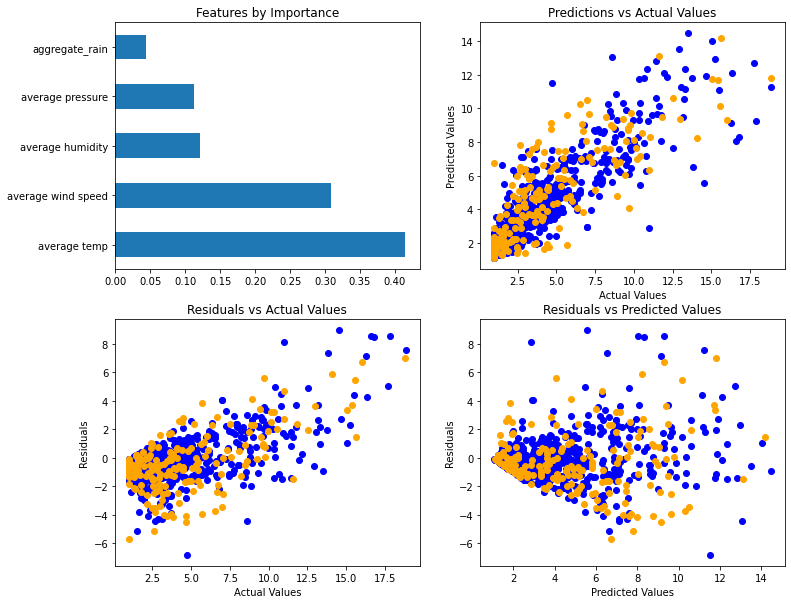

In [31]:
# import all needed libraries


# First we need to take in the data provided to me by the county
df = pd.read_csv(r"C:\Users\donofrio\Desktop\Squito Data3.csv")

# next up instead of ID number we want to assign a simple number to each trap
df["Trap ID"] = df.groupby("ID Number").ngroup()

# sort by Trap ID and then by Lab Date
df = df.sort_values(by=['Lab Date'])

df['Total Mosqutioes'] = df['Number\nof M.'] + df['Number\nof F.']  # calculate Sum of mosqutioes in the area

# We will need to purge some columns we have no use for
df = df.drop(columns=["District", "ID Number", "Entered By", "Result", "Species", "Disease", "Technician",
                      "Supervisorial District", "Test Date", "Cross Street 1", "Cross Street 2", "Number\nof M.",
                      "Number\nof F."])

# Seperate Lab date into month and year
df['Lab Date'] = pd.to_datetime(df['Lab Date'])
df['Month'] = df['Lab Date'].dt.month
df['Year'] = df['Lab Date'].dt.year
df["Day"] = df['Lab Date'].dt.day

df = df.sort_values(by=['Year', 'Month', 'Day', 'Trap ID'])

# Group the DataFrame by date and sum the 'Total Mosquitoes' column for each date
daily_totals = df.groupby('Lab Date')['Total Mosqutioes'].sum()

# Count the number of rows for each date
counts = df.groupby('Lab Date').size()

# Divide the total mosquito count by the count of rows for each date to get the normalized mosquito count
normalized_counts = daily_totals / counts

# Create a new DataFrame with the unique dates and normalized mosquito counts
df2 = pd.DataFrame(
    {'Lab Date': normalized_counts.index, 'Normalized Mosquito Count': normalized_counts.values}).drop_duplicates(
    'Lab Date')

# drop the 00:00:00 from the date
df2['Lab Date'] = df2['Lab Date'].dt.strftime('%Y-%m-%d')

# split the YM column into year and month
df2['Year'] = df2['Lab Date'].str.split('-').str[0]
df2['Month'] = df2['Lab Date'].str.split('-').str[1]
df2['Day'] = df2['Lab Date'].str.split('-').str[2]

# add in weather data
df3 = pd.read_csv(r"C:\Users\donofrio\Desktop\weather_data.csv")

# drop the columns we dont need
df3 = df3.drop(
    columns=["dt", "timezone", "wind_deg", "feels_like", "city_name", "lat", "lon", "visibility", "sea_level",
             "grnd_level", "wind_gust", "rain_3h", "snow_1h", "snow_3h", "clouds_all", "weather_id",
             "weather_description", "weather_icon"])

# replace all rain_1h nans with 0
df3['rain_1h'] = df3['rain_1h'].fillna(0)

# aggregate the rain for the last 3 weeks
df3['aggregate_rain'] = df3['rain_1h'].rolling(504).sum()

# find the average humidity for the last 3 weeks
df3['average humidity'] = df3['humidity'].rolling(504).mean()
# find the average temp for the last 3 weeks
df3['average temp'] = df3['temp'].rolling(504).mean()

# find the average wind speed for the last 3 weeks
df3['average wind speed'] = df3['wind_speed'].rolling(504).mean()

# find the average pressure for the last 3 weeks
df3['average pressure'] = df3['pressure'].rolling(504).mean()

# sort by date
df3 = df3.sort_values(by=['dt_iso'])

# now find the average of the last 3 weeks for each day
df3['average humidity'] = df3['average humidity'].rolling(24).mean()
df3['average temp'] = df3['average temp'].rolling(24).mean()
df3['average wind speed'] = df3['average wind speed'].rolling(24).mean()
df3['average pressure'] = df3['average pressure'].rolling(24).mean()

# select only the rows that have 12:00:00 in the dt_iso column
df3 = df3[df3['dt_iso'].str.contains('12:00:00')]

# remove any rows with nan
df3 = df3.dropna()

# remove the last 9 digits of dt_iso
df3['dt_iso'] = df3['dt_iso'].str[:-19]

# rename dt_iso to Lab Date
df3 = df3.rename(columns={"dt_iso": "Lab Date"})

merged_df = pd.merge(df2, df3, on='Lab Date')

merged_df = merged_df[merged_df['Normalized Mosquito Count'].notna()]

# rename merged_df to df4
df4 = merged_df

#
# calculate the z-scores for each column
z_scores = stats.zscore(df4['Normalized Mosquito Count'])

# identify the rows with z-scores greater than 3 or less than -3
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)

# remove the outliers
df4 = df4[~outliers]

# drop the first 14 rows
df4 = df4.iloc[14:]
df4 = df4.dropna()

# drop unneeded columns
df4 = df4.drop(columns=['temp', 'dew_point', 'temp_max', 'temp_min', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
                        'weather_main'])

# create the feature matrix X and the target variable y
X = df4[['aggregate_rain', 'average temp', 'average humidity', 'average pressure', 'average wind speed']]
y = df4['Normalized Mosquito Count']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3333)

# define the parameter grid to search over
param_grid = {
    'n_estimators': [5, 10, 15],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create a Random Forest model
rf = RandomForestRegressor()

# create a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# create a Random Forest model with the best hyperparameters
rf = RandomForestRegressor(**best_params)

# train the model on the training data
rf.fit(X_train, y_train)

# make predictions on the testing data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# evaluate the performance of the model
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)
print('Mean squared error (train):', mse_train)
print('Mean squared error (test):', mse_test)




# # plot the feature by importance
# feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

fig, ax = plt.subplots(2,2, figsize=(12, 10))


# let's plot the features by importance
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', ax=ax[0,0])
ax[0,0].set_title("Features by Importance")

# let's plot the predictions vs the actual values
ax[0,1].scatter(y_train, y_pred_train, color='blue')
ax[0,1].scatter(y_test, y_pred_test, color='orange')
ax[0,1].set_xlabel("Actual Values")
ax[0,1].set_ylabel("Predicted Values")
ax[0,1].set_title("Predictions vs Actual Values")






# let's plot the residuals vs the actual values
ax[1,0].scatter(y_train, y_train - y_pred_train, color='blue')
ax[1,0].scatter(y_test, y_test - y_pred_test, color='orange')
ax[1,0].set_xlabel("Actual Values")
ax[1,0].set_ylabel("Residuals")
ax[1,0].set_title("Residuals vs Actual Values")

# let's plot the residuals vs the predicted values
ax[1,1].scatter(y_pred_train, y_train - y_pred_train, color='blue')
ax[1,1].scatter(y_pred_test, y_test - y_pred_test, color='orange')
ax[1,1].set_xlabel("Predicted Values")
ax[1,1].set_ylabel("Residuals")
ax[1,1].set_title("Residuals vs Predicted Values")

plt.show()



In [32]:

# Compute the average number of rows per day
avg_rows_per_day = counts.mean()

# Print the result
print('Average number of rows per day:', avg_rows_per_day)



Average number of rows per day: 60.2320987654321


In [33]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



#read in the data
df = pd.read_csv(r"C:\Users\donofrio\Desktop\Florida_data.csv")

#drop columns we dont need

df = df.drop(columns=['CXQ(f)', 'CXQ(m)', 'NAME', 'Unnamed: 7'])

#if a row says ND drop it
df = df[df['AAEG(f)'] != 'ND']
df = df[df['AAEG(m)'] != 'ND']

#sum AAEG(f) and AAEG(m) to get total mosquitos
df['Total Mosquitos'] = df['AAEG(f)'].astype(int) + df['AAEG(m)'].astype(int)

#drop the columns we dont need
df = df.drop(columns=['AAEG(f)', 'AAEG(m)'])

df['Date'] = df.apply(lambda x: datetime.strptime(f"{x['YEAR']} {x['WEEK']} 1", "%Y %W %w"), axis=1)

#strip the time from the date
df['Date'] = df['Date'].dt.date

#drop year and week
df = df.drop(columns=['YEAR', 'WEEK'])

#move the date to the first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

#read in the weather data
df3 = pd.read_csv(r"C:\Users\donofrio\Desktop\florida_weather.csv")


# drop the columns we dont need
df3 = df3.drop(
    columns=["dt", "timezone", "wind_deg", "feels_like", "city_name", "lat", "lon", "visibility", "sea_level",
             "grnd_level", "wind_gust", "rain_3h", "snow_1h", "snow_3h", "clouds_all", "weather_id",
             "weather_description", "weather_icon"])

# replace all rain_1h nans with 0
df3['rain_1h'] = df3['rain_1h'].fillna(0)

# aggregate the rain for the last 3 weeks
df3['aggregate_rain'] = df3['rain_1h'].rolling(504).sum()

# find the average humidity for the last 3 weeks
df3['average humidity'] = df3['humidity'].rolling(504).mean()
# find the average temp for the last 3 weeks
df3['average temp'] = df3['temp'].rolling(504).mean()

# find the average wind speed for the last 3 weeks
df3['average wind speed'] = df3['wind_speed'].rolling(504).mean()

# find the average pressure for the last 3 weeks
df3['average pressure'] = df3['pressure'].rolling(504).mean()

# sort by date
df3 = df3.sort_values(by=['dt_iso'])

# now find the average of the last 3 weeks for each day
df3['average humidity'] = df3['average humidity'].rolling(24).mean()
df3['average temp'] = df3['average temp'].rolling(24).mean()
df3['average wind speed'] = df3['average wind speed'].rolling(24).mean()
df3['average pressure'] = df3['average pressure'].rolling(24).mean()

# select only the rows that have 12:00:00 in the dt_iso column
df3 = df3[df3['dt_iso'].str.contains('12:00:00')]

# remove any rows with nan
df3 = df3.dropna()

# remove the last 9 digits of dt_iso
df3['dt_iso'] = df3['dt_iso'].str[:-19]

# rename dt_iso to Lab Date
df3 = df3.rename(columns={"dt_iso": "Date"})

#convert both date columns to datetime
df['Date'] = pd.to_datetime(df['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])


#merge the two dataframes
df4 = pd.merge(df, df3, on='Date', how='left')

#drop any rows with nan
df4 = df4.dropna()

# drop unneeded columns
df4 = df4.drop(columns=['temp', 'dew_point', 'temp_max', 'temp_min', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
                        'weather_main'])

# calculate the z-scores for each column
z_scores = stats.zscore(df4['Total Mosquitos'])

# identify the rows with z-scores greater than 3 or less than -3
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)

# remove the outliers
df4 = df4[~outliers]


#rename total mosquitos to Normalized Mosquito Count
df4 = df4.rename(columns={"Total Mosquitos": "Normalized Mosquito Count"})





In [30]:
# Create the feature matrix X and the target variable y
X_new = df4[['aggregate_rain', 'average temp', 'average humidity', 'average pressure', 'average wind speed']]
y_new = df4['Normalized Mosquito Count']

# Make predictions on the new dataset
y_pred = rf.predict(X_new)

# Evaluate the performance of the model on the new dataset
mse_new = mean_squared_error(y_new, y_pred)
print('Mean squared error (new data):', mse_new)

r2_new = r2_score(y_new, y_pred)
print('R-squared score (new data):', r2_new)


KeyError: "None of [Index(['aggregate_rain', 'average temp', 'average humidity',\n       'average pressure', 'average wind speed'],\n      dtype='object')] are in the [index]"

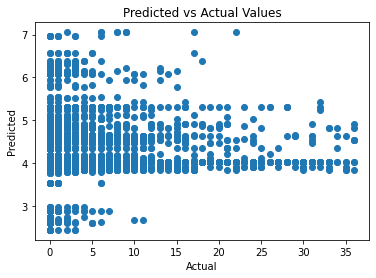

In [26]:
import matplotlib.pyplot as plt

# Create scatter plot of predicted vs actual values
plt.scatter(y_new, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Values')
plt.show()